In [1]:
%load_ext autoreload
%autoreload 2

import poisson_atac as patac
import scanpy as sc

import scipy.sparse
from pytorch_lightning.loggers import WandbLogger
import wandb
import numpy as np
import torch

Global seed set to 0


In [2]:
data_path = "/storage/groups/ml01/workspace/laura.martens/neurips_challenge/data/phase2-private-data/predict_modality/openproblems_bmmc_multiome_phase2_rna"

In [78]:
adata = patac.data.load_neurips(gex=True, batch=None, only_train = False)

#sc.pl.umap(adata, color = "cell_type")

In [4]:
adata_train = adata[adata.obs.is_train].copy()
adata_test = adata[~adata.obs.is_train].copy()

# Run scvi on "corrected" ATAC with poisson loss

In [5]:
#import scvi

#adata = adata[adata.obs.batch == 's1d1'].copy()

adata.layers["counts"].max()

139.0

In [6]:
def compute_embedding(adata, X_emb):      
    adata.obsm['X_emb'] = X_emb
    
    if 'X_umap' in adata.obsm.keys():
        adata.obsm.pop('X_umap')
    if 'umap' in adata.obsm.keys():
        adata.obsm.pop('umap')  
    if 'neighbors' in adata.uns.keys():
        adata.uns.pop('neighbors')
    sc.pp.neighbors(adata, use_rep='X_emb')
    sc.tl.umap(adata)

# Own model

In [7]:
from poisson_atac.seml import evaluation_table, evaluate_embedding, evaluate_test_cells

In [8]:
patac.model.GEXtoATAC.setup_anndata(adata_train, layer="counts", batch_key="batch", adata_gex_obsm_key="X_gex")

SyntaxError: EOL while scanning string literal (1750023833.py, line 1)

In [12]:
model = patac.model.GEXtoATAC(adata_train, n_latent=130, use_layer_norm="encoder", n_hidden=150)

13431


In [13]:
model.module

GEXTOATACVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=13431, out_features=150, bias=True)
          (1): None
          (2): LayerNorm((150,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=150, out_features=150, bias=True)
          (1): None
          (2): LayerNorm((150,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=150, out_features=130, bias=True)
    (var_encoder): Linear(in_features=150, out_features=130, bias=True)
  )
  (decoder): LinearDecoderSCVI(
    (factor_regressor): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features

In [ ]:
#setup logger
logger = WandbLogger(project=f"poisson_atac")
logger.watch(model.module, log='all')
#
#train model
model.train(logger=logger,train_size=0.8, validation_size=0.1, early_stopping=True, batch_size=128, max_epochs =500, lr = 5e-4)
wandb.finish()

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: lauradm (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/wandb/sdk/lib/ipython.py:46: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML  # type: ignore


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 56/500:  11%|█         | 56/500 [1:15:59<10:20:50, 83.90s/it, loss=1.94e+08, v_num=s8mu]

In [ ]:
model.save("/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/models/poisson_atac_count_gex_neurips")

# Evaluate Model

In [79]:
adata.obs["old_batch"] = adata.obs["batch"].copy()

In [91]:
adata.obs["batch"][adata.obs.batch.isin(['s4d1', 's4d8','s4d9'])] = adata.obs["batch"][adata.obs.batch.isin(['s4d1', 's4d8','s4d9'])].map({'s4d1': 's1d1', 's4d8':"s1d2", 's4d9':"s2d1"})

In [93]:
patac.model.GEXtoATAC.setup_anndata(adata, layer="counts", batch_key="batch", adata_gex_obsm_key="X_gex")

INFO     Generating sequential column names                                                  


2022-03-02 13:52:31 (INFO): Generating sequential column names


In [94]:
model = patac.model.GEXtoATAC.load("/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/models/poisson_atac_count_gex_neurips", adata=adata)

13431


In [102]:
model.module

GEXTOATACVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=13431, out_features=150, bias=True)
          (1): None
          (2): LayerNorm((150,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=150, out_features=150, bias=True)
          (1): None
          (2): LayerNorm((150,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=150, out_features=130, bias=True)
    (var_encoder): Linear(in_features=150, out_features=130, bias=True)
  )
  (decoder): LinearDecoderSCVI(
    (factor_regressor): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features

In [95]:
X_emb = model.get_latent_representation()

In [97]:
compute_embedding(adata, X_emb)

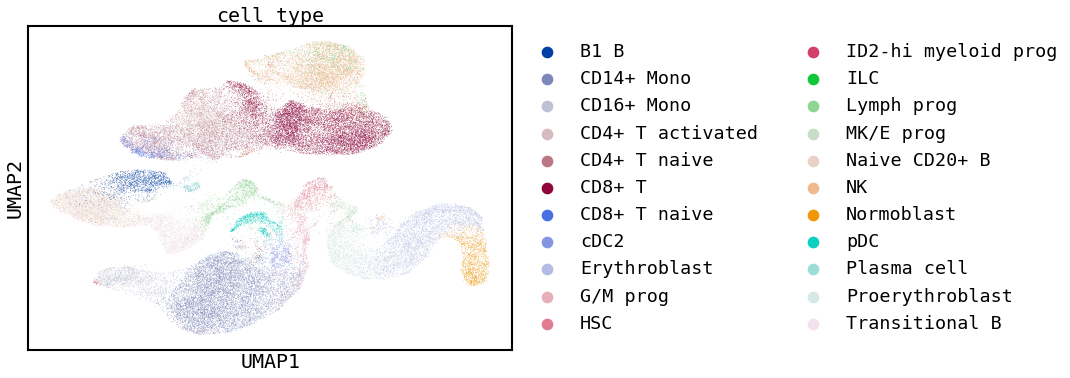

In [99]:
sc.pl.umap(adata, color = ["cell_type"],save="neurips")

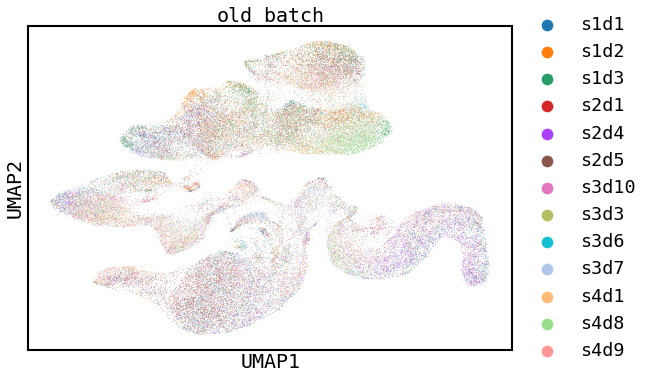

In [101]:
sc.pl.umap(adata, color = ["old_batch"],save="neurips")

In [104]:
adata.obs.is_train = adata.obs.is_train.astype(str)

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'is_train' as categorical


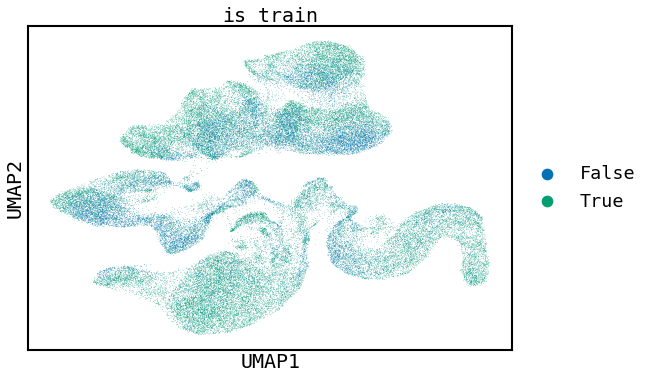

In [105]:
sc.pl.umap(adata, color = ["is_train"])

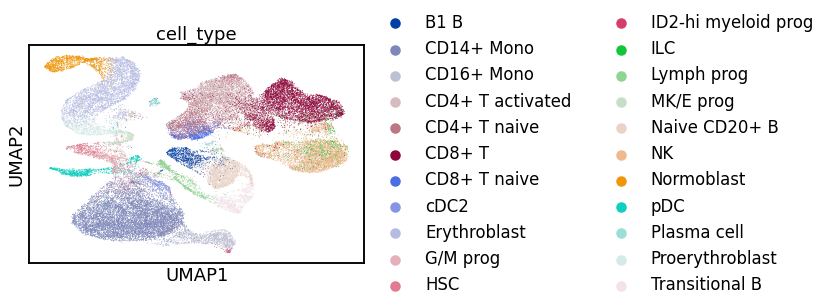

In [15]:
sc.pl.umap(adata_train, color = ["cell_type"],save="neurips")

In [16]:
evaluate_embedding(adata_train, X_emb, labels_key = "cell_type")

NMI...
ARI...


,0
NMI_cluster/label,0.764178
ARI_cluster/label,0.724273
ASW_label,NaN
ASW_label/batch,NaN
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,NaN
graph_conn,NaN
kBET,NaN


In [20]:
adata_test.obs.batch = adata_test.obs.batch.map({'s4d1': 's1d1', 's4d8':"s1d2", 's4d9':"s2d1"})

In [18]:
patac.model.GEXtoATAC.setup_anndata(adata_test, layer="counts", batch_key="batch", adata_gex_obsm_key="X_gex")

INFO     Generating sequential column names                                                  


In [ ]:
# Try different random peaks

In [39]:
y_median = model.get_normalized_accessibility(adata_test, library = adata_train.obs.size_factor.median())
y_pred = model.get_accessibility_estimates(adata_test, return_numpy= True)



INFO     Input AnnData requires setup with AnnData the model was initialized with. Attempting
         to transfer setup with initial AnnData.                                             
INFO     Input AnnData requires setup with AnnData the model was initialized with. Attempting
         to transfer setup with initial AnnData.                                             


In [42]:
results_df = []
for i in range(5):
    print(i)
    random_peaks = np.random.choice(np.arange(adata_test.shape[0]), 10000)
    y_true = adata_test[:, random_peaks].X.A
    predictions = {'True size factor': y_pred[:, random_peaks], "Mean size factor": y_median[:, random_peaks]}
    results_df.append(evaluation_table(y_true, predictions))

0
1
2


KeyboardInterrupt: 

In [50]:
results = pd.concat(results_df)

In [29]:
results

,Model
auroc,0.874559
average_precision,0.218124
bce,1170.578340
rmse,0.174407


In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import utils
results["Neurips Winner"] = pd.Series({'auroc': np.nan, 'average_precision': np.nan, 'bce': np.nan, "rmse": 0.1774})

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/sacred/config/custom_containers.py:273: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if hasattr(np, npf):
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/sacred/config/custom_containers.py:274: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

In [56]:
sns_df=results.loc['rmse'].melt(var_name = "Model", value_name = "rmse")

<AxesSubplot:xlabel='Model', ylabel='rmse'>

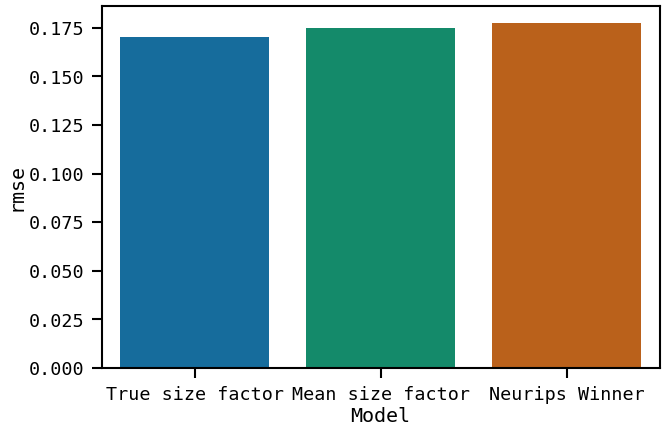

In [71]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=sns_df, x = "Model", y ="rmse", ax=ax, ci ="sd")

# TODO
* SOLVE how to train on unseen batches (OR train without batches!)
* SOLVE docker??
* Swap mean with median

# Check seml

In [5]:
patac.seml.experiment_runner_atac_to_atac.ExprimentWrapper()

AttributeError: module 'poisson_atac.seml' has no attribute 'experiment_runner_atac_to_atac'

In [12]:
patac.model.PEAKVI.setup_anndata(atac, layer="counts")

In [14]:
model =  patac.model.PEAKVI.load( "/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/models/poisson_atac_count", adata=atac)

In [32]:
X_emb = model.get_latent_representation(atac)

In [20]:
compute_embedding(adata, X_emb)

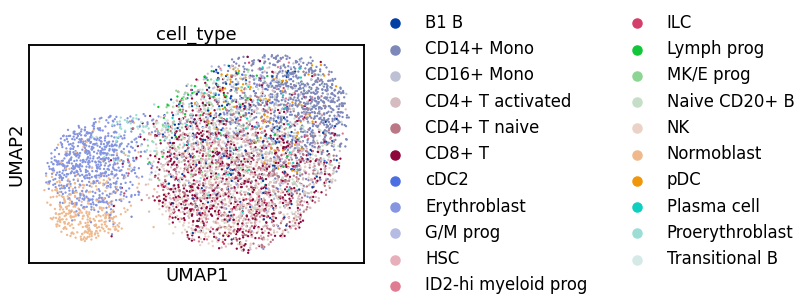

In [22]:
sc.pl.umap(adata, color = ["cell_type"])

In [22]:
model.module

CountVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=116490, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=341, out_features=341, bias=True)
          (1): None
          (2): LayerNorm((341,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=341, out_features=130, bias=True)
    (var_encoder): Linear(in_features=341, out_features=130, bias=True)
  )
  (decoder): LinearDecoderSCVI(
    (factor_regressor): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=13